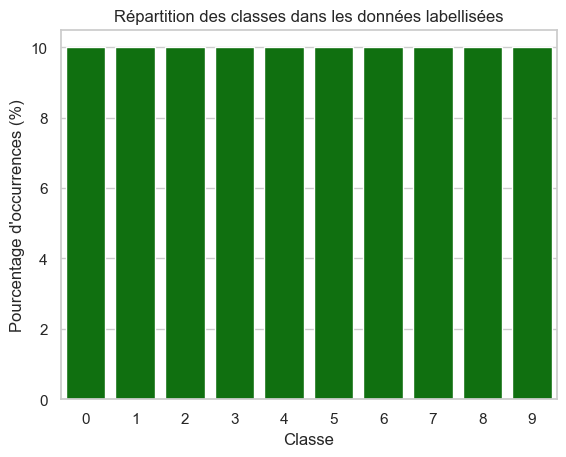

In [2]:
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


# Charger le dataset complet
full_trainset = datasets.MNIST(root='./data', train=True, download=True)

# Indices pour chaque classe
class_indices = {i: [] for i in range(10)}
for idx, (_, label) in enumerate(full_trainset):
    class_indices[label].append(idx)

# Sélectionner 10 indices par classe pour les données labellisées
labeled_indices = []
for cls in range(10):
    labeled_indices.extend(random.sample(class_indices[cls], 10))

# Indices restants pour les données non labellisées
unlabeled_indices = list(set(range(len(full_trainset))) - set(labeled_indices))

# Sous-ensembles
unlabeled_dataset = Subset(full_trainset, unlabeled_indices)  # 59 900 données non labellisées
labeled_dataset = Subset(full_trainset, labeled_indices)      # 100 données labellisées




# Analyse de la répartition des classes dans les données labellisées
class_count_labelled = {}
for i in range(len(labeled_indices)):
    label = full_trainset.targets[labeled_indices[i]].item()  # Récupérer les labels des indices labellisés
    if label not in class_count_labelled:
        class_count_labelled[label] = 0
    class_count_labelled[label] += 1

# Création d'un DataFrame pour faciliter la visualisation
df_labelled = pd.DataFrame(class_count_labelled.items(), columns=["Label", "Occurrence"])
df_labelled["Occurrence (%)"] = (df_labelled["Occurrence"] / len(labeled_indices)) * 100

# Visualisation avec Seaborn
sns.set(style="whitegrid")
sns.barplot(x="Label", y="Occurrence (%)", data=df_labelled, color="green")
plt.title("Répartition des classes dans les données labellisées")
plt.xlabel("Classe")
plt.ylabel("Pourcentage d'occurrences (%)")
plt.show()



In [6]:
import torch
import torch.nn as nn
from torchvision import transforms

# Vérifier si un GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Utilisation de :", device)



contrastive_transforms = transforms.Compose([

    transforms.RandomResizedCrop(size=28, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.GaussianBlur(kernel_size=9),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))


])

class SimCLRDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]  # Ignorer les labels pour le pré-entraînement
        img1 = self.transform(img)
        img2 = self.transform(img)
        return img1, img2

    def __len__(self):
        return len(self.dataset)

# Dataset avec transformations contrastives
simclr_unlabeled_dataset = SimCLRDataset(unlabeled_dataset, contrastive_transforms)
unlabeled_loader = DataLoader(simclr_unlabeled_dataset, batch_size=256, shuffle=True)




import torch
import torch.nn as nn

# Backbone CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.flatten(x)
        return x

# Tête de projection
class ProjectionHead(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ProjectionHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Combinaison Backbone + Projection Head
cnn = SimpleCNN()
projection_head = ProjectionHead(input_dim=3136, output_dim=128)  # Adapter input_dim si nécessaire
simclr_model = nn.Sequential(cnn, projection_head).to(device)




import torch.nn.functional as F

def contrastive_loss(projections1, projections2, temperature=0.07):
    z1 = F.normalize(projections1, dim=1)
    z2 = F.normalize(projections2, dim=1)
    similarity_matrix = torch.matmul(z1, z2.T) / temperature
    batch_size = z1.size(0)
    labels = torch.arange(batch_size).to(z1.device)
    loss1 = F.cross_entropy(similarity_matrix, labels)
    loss2 = F.cross_entropy(similarity_matrix.T, labels)
    return (loss1 + loss2) / 2


Utilisation de : cpu


In [7]:
# Pre-entrainement


import torch.optim as optim

# Optimiseur
optimizer = optim.Adam(simclr_model.parameters(), lr=1e-3)

# Boucle d'entraînement
simclr_model.train()
epochs = 10  # Ajuster le nombre d'époques selon vos besoins
for epoch in range(epochs):
    total_loss = 0
    for (view1, view2) in unlabeled_loader:
        view1, view2 = view1.to(device), view2.to(device)

        # Projections
        projections1 = simclr_model(view1)
        projections2 = simclr_model(view2)

        # Calcul de la perte
        loss = contrastive_loss(projections1, projections2)
        total_loss += loss.item()

        # Optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(unlabeled_loader)}")


Epoch 1/10, Loss: 1.7557378467331586
Epoch 2/10, Loss: 0.8578567410636152
Epoch 3/10, Loss: 0.6877784471735995
Epoch 4/10, Loss: 0.5936208301120334
Epoch 5/10, Loss: 0.528209313750267
Epoch 6/10, Loss: 0.49893631996252596
Epoch 7/10, Loss: 0.46051965730312544
Epoch 8/10, Loss: 0.4365367317556316
Epoch 9/10, Loss: 0.4216135058902268
Epoch 10/10, Loss: 0.404738251470093


In [29]:
def progressive_fine_tuning(pretrained_model, labeled_dataset, val_dataset, num_classes=10, max_labels=100, step=10, device="cpu"):
    """
    Effectue un fine-tuning progressif sur un modèle préentraîné.
    
    Args:
        pretrained_model: Modèle préentraîné à fine-tuner.
        labeled_dataset: Dataset contenant les données labellisées.
        val_dataset: Dataset de validation pour évaluer les performances.
        num_classes: Nombre de classes dans le dataset.
        max_labels: Nombre total de données labellisées disponibles.
        step: Taille de l'incrément des données labellisées.
        device: "cpu" ou "cuda" pour entraîner sur GPU.
    
    Returns:
        history: Un dictionnaire contenant la loss et l'accuracy pour chaque étape.
    """
    import torch.nn as nn
    from torch.utils.data import DataLoader, Subset
    import numpy as np

    # Historique des performances
    history = {"num_labels": [], "accuracy": [], "loss": []}

    # Boucle sur les tailles croissantes de données labellisées
    for num_labels in range(step, max_labels + 1, step):
        print(f"\nFine-tuning avec {num_labels} données labellisées...")

        # Sous-échantillonnage du dataset labellisé
        indices = np.random.choice(len(labeled_dataset), num_labels, replace=False)
        subset = Subset(labeled_dataset, indices)
        train_loader = DataLoader(subset, batch_size=32, shuffle=True, drop_last=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        # Modèle pour fine-tuning
        model = nn.Sequential(
            pretrained_model,
            nn.Linear(128, num_classes)  # Tête de classification
        ).to(device)

        # Optimiseur et fonction de perte
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        # Entraînement
        model.train()
        for epoch in range(5):  # 5 époques pour chaque étape
            for inputs, labels in train_loader:
                if isinstance(inputs, (list, tuple)):  # Gérer les vues augmentées si présentes
                    inputs = inputs[0]
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Évaluation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                if isinstance(inputs, (list, tuple)):  # Cas où les inputs contiennent plusieurs vues
                    inputs = inputs[0]  # Utilisez la première vue pour l'évaluation
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        avg_loss = val_loss / len(val_loader)

        # Stockage des performances
        history["num_labels"].append(num_labels)
        history["accuracy"].append(accuracy)
        history["loss"].append(avg_loss)
        print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    return history


In [30]:
# Fine-tuning progressif
history = progressive_fine_tuning(
    pretrained_model=simclr_model,
    labeled_dataset=labeled_dataset,
    val_dataset=valset,
    num_classes=10,
    max_labels=100,
    step=10,
    device=device
)

# Plot des résultats
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history["num_labels"], history["accuracy"], marker="o", label="Accuracy")
plt.xlabel("Nombre de données étiquetées")
plt.ylabel("Accuracy")
plt.title("Accuracy en fonction des données étiquetées")
plt.grid()
plt.legend()
plt.show()

# Loss
plt.figure(figsize=(12, 6))
plt.plot(history["num_labels"], history["loss"], marker="o", color="red", label="Loss")
plt.xlabel("Nombre de données étiquetées")
plt.ylabel("Loss")
plt.title("Loss en fonction des données étiquetées")
plt.grid()
plt.legend()
plt.show()



Fine-tuning avec 10 données labellisées...
Validation Loss: 2.3153, Accuracy: 0.0767

Fine-tuning avec 20 données labellisées...
Validation Loss: 2.3092, Accuracy: 0.0952

Fine-tuning avec 30 données labellisées...
Validation Loss: 2.3075, Accuracy: 0.0960

Fine-tuning avec 40 données labellisées...


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

In [27]:
def progressive_fine_tuning(pretrained_model, labeled_dataset, val_dataset, num_classes=10, max_labels=100, step=10, device="cpu"):
    """
    Effectue un fine-tuning progressif sur un modèle préentraîné.
    
    Args:
        pretrained_model: Modèle préentraîné à fine-tuner.
        labeled_dataset: Dataset contenant les données labellisées.
        val_dataset: Dataset de validation pour évaluer les performances.
        num_classes: Nombre de classes dans le dataset.
        max_labels: Nombre total de données labellisées disponibles.
        step: Taille de l'incrément des données labellisées.
        device: "cpu" ou "cuda" pour entraîner sur GPU.
    
    Returns:
        history: Un dictionnaire contenant la loss et l'accuracy pour chaque étape.
    """
    import torch.nn as nn
    from torch.utils.data import DataLoader, Subset
    import numpy as np

    # Historique des performances
    history = {"num_labels": [], "accuracy": [], "loss": []}

    # Boucle sur les tailles croissantes de données labellisées
    for num_labels in range(step, max_labels + 1, step):
        print(f"\nFine-tuning avec {num_labels} données labellisées...")

        # Sous-échantillonnage du dataset labellisé
        indices = np.random.choice(len(labeled_dataset), num_labels, replace=False)
        subset = Subset(labeled_dataset, indices)
        
        # Réduction de la taille du batch pour correspondre au nombre de données
        batch_size = min(num_labels, 32)  # Si moins de données que le batch_size, on réduit
        train_loader = DataLoader(subset, batch_size=batch_size, shuffle=True, drop_last=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        # Modèle pour fine-tuning
        model = nn.Sequential(
            pretrained_model,
            nn.Linear(128, num_classes)  # Tête de classification
        ).to(device)

        # Optimiseur et fonction de perte
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        # Entraînement
        model.train()
        for epoch in range(5):  # 5 époques pour chaque étape
            for inputs, labels in train_loader:
                if isinstance(inputs, (list, tuple)):  # Gérer les vues augmentées si présentes
                    inputs = inputs[0]
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Évaluation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                if isinstance(inputs, (list, tuple)):  # Cas où les inputs contiennent plusieurs vues
                    inputs = inputs[0]  # Utilisez la première vue pour l'évaluation
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        avg_loss = val_loss / len(val_loader)

        # Stockage des performances
        history["num_labels"].append(num_labels)
        history["accuracy"].append(accuracy)
        history["loss"].append(avg_loss)
        print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    return history


In [ ]:
# Fine-tuning progressif
history = progressive_fine_tuning(
    pretrained_model=simclr_model,
    labeled_dataset=labeled_dataset,
    val_dataset=valset,
    num_classes=10,
    max_labels=100,
    step=10,
    device=device
)

# Plot des résultats
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history["num_labels"], history["accuracy"], marker="o", label="Accuracy")
plt.xlabel("Nombre de données étiquetées")
plt.ylabel("Accuracy")
plt.title("Accuracy en fonction des données étiquetées")
plt.grid()
plt.legend()
plt.show()

# Loss
plt.figure(figsize=(12, 6))
plt.plot(history["num_labels"], history["loss"], marker="o", color="red", label="Loss")
plt.xlabel("Nombre de données étiquetées")
plt.ylabel("Loss")
plt.title("Loss en fonction des données étiquetées")
plt.grid()
plt.legend()
plt.show()


In [25]:
print(f"Longueur du dataset labellisé : {len(labeled_dataset)}")


Longueur du dataset labellisé : 100
